# **Grid NPP Estimation and FAO Yield Disaggregation**

## **Import Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap
import geopandas as gpd
import rasterio as rio
from geemap import cartoee
import cartopy.crs as ccrs
import geedim
from rasterio.mask import mask
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams['font.serif'] = "Times New Roman"

## **Initialize a Map Object**

In [2]:
# ee.Authenticate()

In [3]:
# ee.Initialize(project="krishnagopal-iit-roorkee")

In [4]:
Map = geemap.Map(basemap="Esri.WorldImagery")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **Import the Region of Interest**

In [5]:
# Read the shapefile of the region of interest
roi_gdf = gpd.read_file(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\Africa_Country_Boundary\africa_administrative.shp")

# Read the shapefile of the region of interest in the form of EE FeatureCollection
roi_ee = ee.FeatureCollection("projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/africa_administrative")
roi_style = {
    "fillColor": "00000000",
    "color": "black",
    "width": 0.5
}
Map.addLayer(roi_ee.style(**roi_style), {}, "Africa Boundary")
Map.centerObject(roi_ee, 4)

## **Read all the Required Dataset**
1. Crop Calendar
2. FAO Yield
3. Crop Mask

### **Crop Calendar Data Preparation for Major and Minor Season**

In [6]:
# Read the Major crop calendar dataset
major_crop_calendar_df = pd.read_excel(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets\crop_calendar_ssa.xlsx", sheet_name="maize_major")
major_crop_calendar_df = major_crop_calendar_df[["country", "plant_start", "harvest_end"]]
major_crop_calendar_df.replace(to_replace={"Côte d'Ivoire": "Cote d'Ivoire"}, inplace=True)
print(major_crop_calendar_df.shape)
major_crop_calendar_df.head()

(59, 3)


,country,plant_start,harvest_end
0,Abyei,91,262
1,Algeria,56,337
2,Angola,244,120
3,Benin,60,273
4,Botswana,319,166


In [7]:
# Read the Minor crop calendar dataset
minor_crop_calendar_df = pd.read_excel(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets\crop_calendar_ssa.xlsx", sheet_name="maize_second")
minor_crop_calendar_df = minor_crop_calendar_df[["country", "plant_start", "harvest_end"]]
minor_crop_calendar_df.dropna(inplace=True)
minor_crop_calendar_df.replace(to_replace={"Côte d'Ivoire": "Cote d'Ivoire"}, inplace=True)
print(minor_crop_calendar_df.shape)
minor_crop_calendar_df.head()

(26, 3)


,country,plant_start,harvest_end
2,Angola,305.0,151.0
3,Benin,213.0,31.0
5,Burkina Faso,213.0,31.0
6,Burundi,32.0,212.0
7,Cameroon,213.0,31.0


### **Read the FAO Country Level Yield Data**

In [8]:
# Read the FAO data
fao_yield_df = pd.read_csv(r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\FAOSTAT_data_SSA_Maize_1961-2022.csv")

# Change the name of the few countries if needed
new_country_names = {
    "C?te d'Ivoire": "Cote d'Ivoire",
    "Cabo Verde": "Cape Verde",
    "Eswatini": "Swaziland"
}

fao_yield_df.replace(to_replace=new_country_names, inplace=True)
print(fao_yield_df.shape)
fao_yield_df.head()

(3043, 5)


,Area,Element,Item,Year,Yield(tons/ha)
0,Algeria,Yield,Maize (corn),1961,0.9746
1,Algeria,Yield,Maize (corn),1962,0.5400
2,Algeria,Yield,Maize (corn),1963,1.0716
3,Algeria,Yield,Maize (corn),1964,1.1703
4,Algeria,Yield,Maize (corn),1965,1.1000


Number of countries in the FAO data: 53


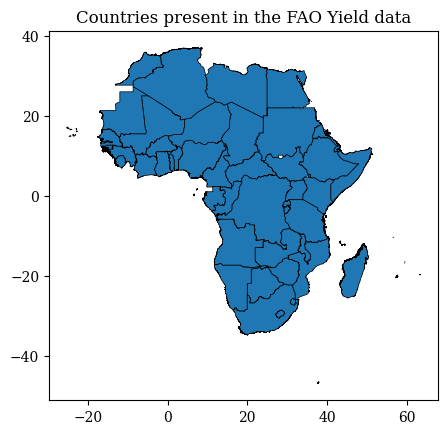

In [9]:
# Check the number of countries in the FAO data
print("Number of countries in the FAO data:", fao_yield_df["Area"].nunique())

# Store the name of the countries in a specific variable
fao_countries = fao_yield_df["Area"].unique()

# Plot the countries present in the FAO yield data
roi_gdf[roi_gdf["ADM0_NAME"].isin(fao_countries)].plot(edgecolor="black", linewidth=0.5)
plt.title("Countries present in the FAO Yield data");

### **Prepare the Harvested Area (If Needed)**

In [10]:
# # Read the Maize Harvested Area dataset
# maize_harv_area = ee.Image("projects/krishnagopal-msc-dissertation/assets/maize_HarvestedAreaHectares")\
#                     .clip(roi_ee)

# harv_area_vis = {
#     "bands": ["b1"],
#     "min": 0,
#     "max": 2550,
#     "palette": ['#d73027','#fc8d59','#fee08b','#d9ef8b','#91cf60','#1a9850']
# }

# Map.addLayer(maize_harv_area, harv_area_vis, "Maize Harvested Area", False)

In [12]:
# # Plot the Maize harvested area
# fig = plt.figure(figsize=(7, 7))

# region = [-19.4, -37.0, 54.2, 39.3]

# ax = cartoee.get_map(maize_harv_area, 
#                      cmap="viridis", 
#                      vis_params={"min": 0, "max": 2550},
#                      region=region)

# cb = cartoee.add_colorbar(ax=ax, vis_params={"min": 0, "max": 2250}, loc="right", 
#                           cmap="viridis", label="Maize Harvested Area (hectares)")

# ax.set_title("Average number of hectares harvested per land-area\nof a gridcell during the 1997-2003")

# plt.show()

### **Prepare the Cropland Mask**

In [13]:
# # Prepare the Cropland mask from ESRI LULC dataset
# # Read the ESRI LULC 10M data and filter it with ROI
# esri_lulc_ts= ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")
# esri_cropland_mask = esri_lulc_ts.filterBounds(africa_ee.geometry().bounds())\
#                                  .mode()\
#                                  .eq(5)\
#                                  .selfMask()\
#                                  .clip(africa_ee.geometry().bounds())

# Read the extracted crop mask
esri_cropland_mask = ee.Image("projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/ssa_cropland_mask")
esri_cropland_vis = {"min": 0, "max": 1, "palette": ["#FFDB5C"]}
Map.addLayer(esri_cropland_mask, esri_cropland_vis, "ESRI Cropland Mask")

In [13]:
# # Extract the crop mask
# cropmask_export_task = ee.batch.Export.image.toAsset(image=cropland_mask,
#                                                      assetId="projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/ssa_cropland_mask",
#                                                      description="SSA_Cropland_Mask",
#                                                      region=africa_ee.geometry().bounds(),
#                                                      scale=10,
#                                                      maxPixels=1e13)

# cropmask_export_task.start()

In [14]:
# Read the exported LULC and calculate the total area of the croplands
# The 'esri_cropland_mask' has been exported using 'geedim' package in another notebook

# Calculate raster area for each country
cropmask_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\global_crop_mask\africa_cropland_mask.tif"

# Read the image using rasterio
cropmask = rio.open(cropmask_path, "r")

# Create a function to calculate raster area per polygon
def calculate_raster_area(raster, gdf, crs="EPSG:3857"):

    # Change the CRS of the geodataframe
    gdf = gdf.to_crs(crs)

    data = {"country": [],
            "crop_area": []}

    for _, row in tqdm(gdf.iterrows()):
        geom = [row["geometry"]]

        # Clip the raster with the polygon
        out_image, out_transform = mask(raster, geom, crop=True)

        # Calculate the area
        out_image = out_image[0]  # Get the first band
        pixel_area = raster.res[0] * raster.res[1]  # Calculate the area of a pixel
        polygon_area = np.sum(out_image > 0) * pixel_area  # Area where the pixel value is greater than 0

        data["country"].append(row["ADM0_NAME"])
        data["crop_area"].append(polygon_area)

    return pd.DataFrame(data)

# Apply the function
crop_area = calculate_raster_area(cropmask, roi_gdf, crs="EPSG:3857")

59it [00:25,  2.30it/s]


In [16]:
# Calculate the area ratio of crop land and number of points to be generated
crop_area["area_ratio"] = crop_area["crop_area"] / crop_area["crop_area"].sum()

# Calculate the crop area in square kilometers
crop_area["crop_area_sq_km"] = crop_area["crop_area"] / 1e6

# Calculate the number of sample points to be generated for each country
total_samples = 120000
crop_area["no_of_samples"] = crop_area["area_ratio"] * total_samples
crop_area["no_of_samples"] = crop_area["no_of_samples"].astype("int")
print(crop_area.shape)
crop_area.head()

(59, 5)


,country,crop_area,area_ratio,crop_area_sq_km,no_of_samples
0,Sudan,1.044686e+11,0.065443,104468.5625,7853
1,Angola,1.958119e+10,0.012266,19581.1875,1471
2,Benin,8.968000e+09,0.005618,8968.0000,674
3,Botswana,6.185062e+09,0.003875,6185.0625,464
4,Burkina Faso,3.093438e+09,0.001938,3093.4375,232


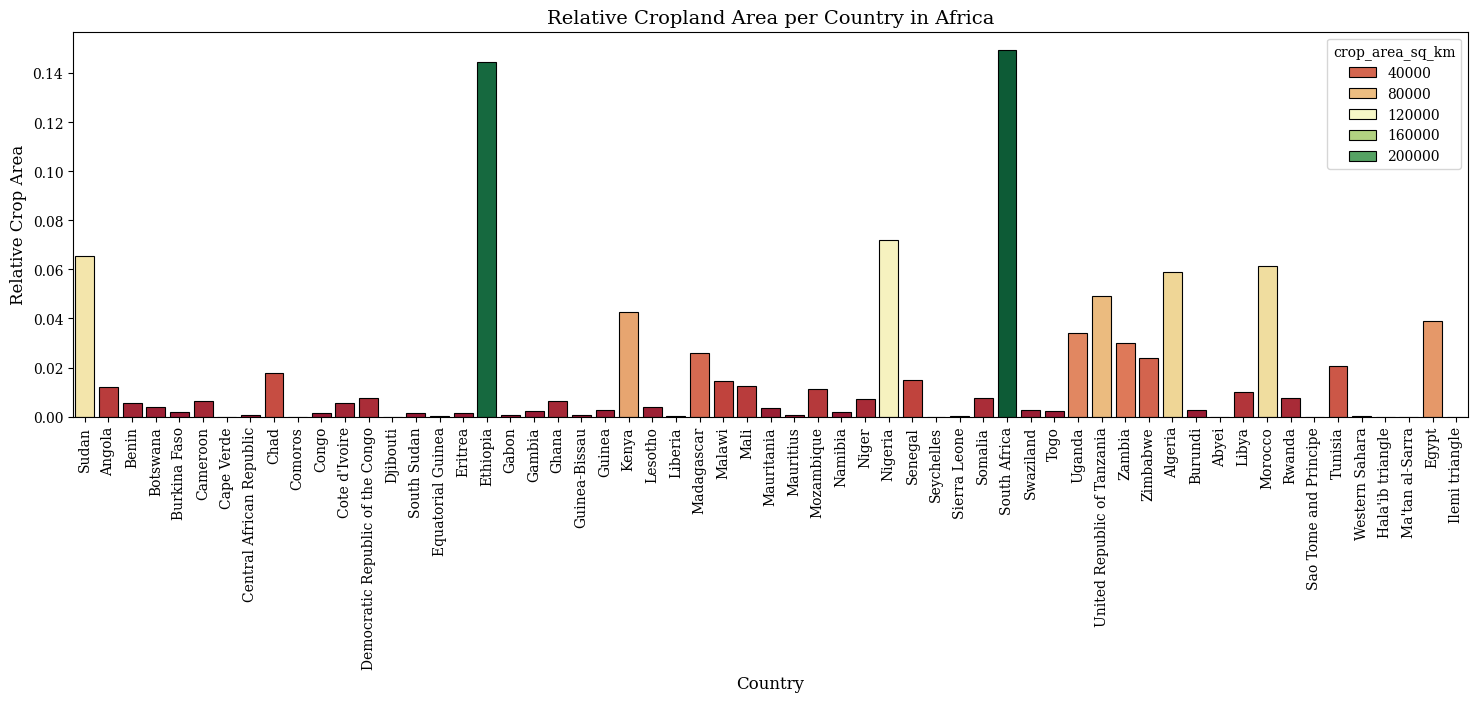

In [17]:
# Plot the crop area ratio per country
plt.figure(figsize=(18, 5))

ax = sns.barplot(data=crop_area, x="country", y="area_ratio", hue="crop_area_sq_km", palette="RdYlGn", 
                 edgecolor="black", linewidth=0.8)
ax.set_ylabel("Relative Crop Area", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.set_title("Relative Cropland Area per Country in Africa", fontsize=14)
plt.show()

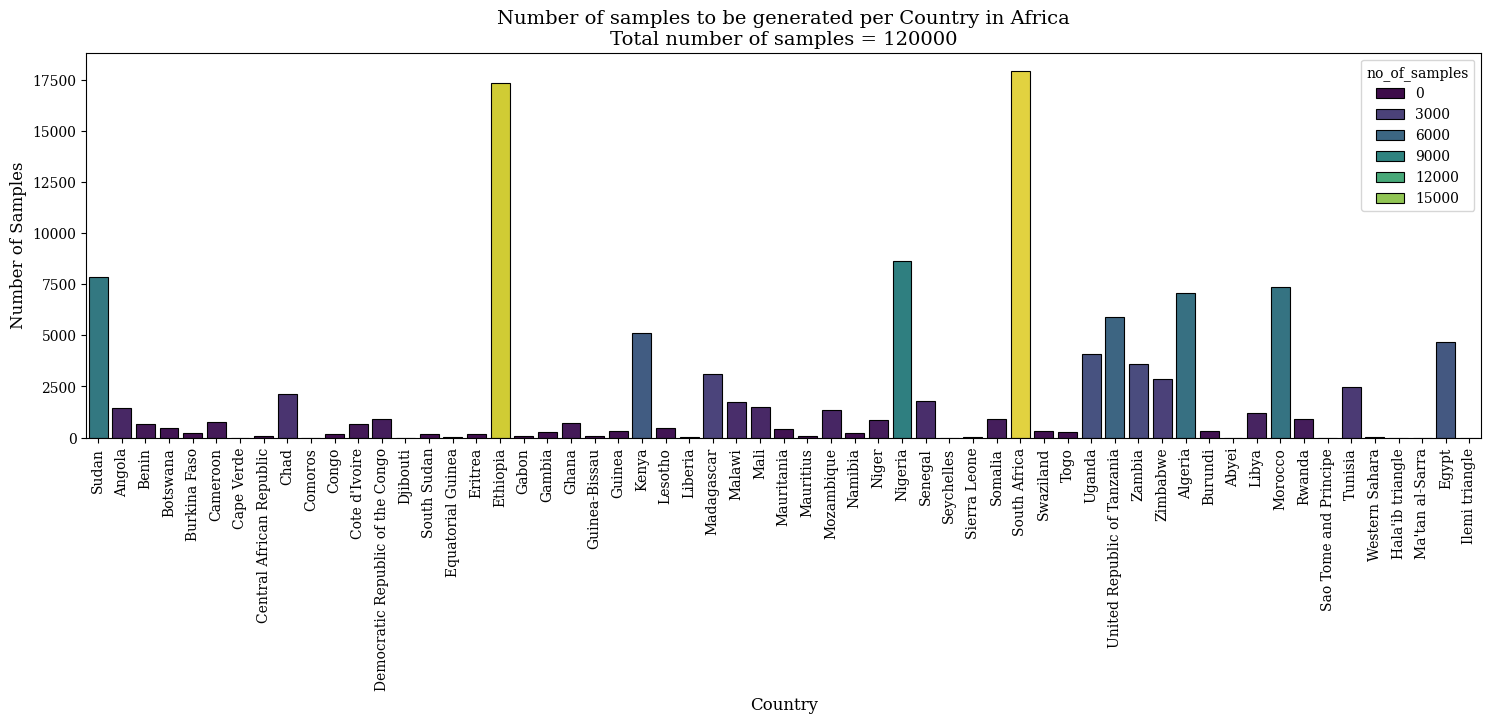

In [18]:
# Plot the Number of samples to be generated per country
plt.figure(figsize=(18, 5))

ax = sns.barplot(data=crop_area, x="country", y="no_of_samples", hue="no_of_samples", palette="viridis",
                 edgecolor="black", linewidth=0.8)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.set_title(f"Number of samples to be generated per Country in Africa\nTotal number of samples = {total_samples}", fontsize=14)
plt.show()

### **Generate Sample Points based on Koppen-Geiger Climate Classes**

In [19]:
# Read the Koppen-Geiger climate classification as an ImageCollection
koppen_climate_class = ee.Image("users/krish-iit-roorkee/koppen_geiger_climate_classification")

In [21]:
# Write a function to generate sample based on stratified approach on the climate classes
def generate_samples_by_clim_class(country_name, seed):

    country_geom = roi_ee.filter(ee.Filter.eq("ADM0_NAME", country_name)).first()\
                        .geometry()
        
    # Clip the country  crop mask
    country_crop_mask = esri_cropland_mask.clip(country_geom)\

    # Clip the Koppen climate class
    koppen_climate_class_masked = koppen_climate_class.updateMask(country_crop_mask)

    # Calculate the area of each class
    area_image = ee.Image.pixelArea().addBands(koppen_climate_class_masked)
    areas = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName="b1"),
        geometry=country_geom,
        scale=928,
        maxPixels=1e16)
    areas = areas.getInfo()
    areas_df = pd.DataFrame(areas["groups"])
    areas_df["area_proportion"] = areas_df["sum"] / areas_df["sum"].sum()

    # Extract the total number of samples to be generated in the country
    total_points = crop_area[crop_area["country"]==country_name]["no_of_samples"].values[0]
    areas_df["no_of_samples"] = (areas_df["area_proportion"] * total_points).astype("int")

    # Generate random points based on stratified sampling on climate classes
    stratified_samples = koppen_climate_class_masked.stratifiedSample(
            numPoints=0,
            classBand="b1",
            region=country_geom.bounds(), 
            scale=928,
            classValues=list(areas_df["b1"]),
            classPoints=list(areas_df["no_of_samples"]),
            seed=seed, 
            dropNulls=True,
            geometries=True)
    
    return stratified_samples

In [22]:
# # Create a final dataframe to store the samples of all the countries
# final_samples = pd.DataFrame()

# # Iterate the function over all the countries
# for country in tqdm(fao_countries):
#     print(country, end=": ")
    
#     try:
#         no_of_samples = crop_area[crop_area["country"]==country]["no_of_samples"].values[0]

#         if no_of_samples > 10:
#             country_samples = generate_samples_by_clim_class(country, seed=42)
#             country_samples_gdf = geemap.ee_to_gdf(country_samples)
#             country_samples_gdf.rename(columns={"b1": "clim_class"}, inplace=True)
#             country_samples_gdf["country"] = country
#             country_samples_gdf = country_samples_gdf[["country", "clim_class", "geometry"]]
#             final_samples = pd.concat((final_samples, country_samples_gdf), axis=0)
#             print(no_of_samples, "(Done)")

#         else:
#             print(no_of_samples, "(Skipped)")

#     except:
#         print("*******************Error*******************")
#         continue

In [23]:
# # Export the sample points
# final_samples.reset_index(drop=True, inplace=True)
# final_samples["point_id"] = final_samples.index
# final_samples = final_samples[["point_id", "country", "clim_class", "geometry"]]

output_path = r"D:\Research Works\Agriculture\ssa_crop_yield_forecasting\datasets\processed_datasets\samples"
# final_samples.to_file(os.path.join(output_path, "africa_samples.shp"), driver="ESRI Shapefile")

In [24]:
# Read the exported samples
samples_gdf = gpd.read_file(os.path.join(output_path, "africa_samples.shp"))
samples_ee = ee.FeatureCollection("projects/krishnagopal-iit-roorkee/assets/ssa-crop-yield-forecasting/africa_samples")
print(samples_gdf.shape)
samples_gdf.head()

(117345, 4)


,point_id,country,clim_class,geometry
0,0,Algeria,4,POINT (5.23822 35.56770)
1,1,Algeria,4,POINT (1.79530 29.07367)
2,2,Algeria,4,POINT (6.43865 30.60756)
3,3,Algeria,4,POINT (9.38139 24.55536)
4,4,Algeria,4,POINT (2.47888 27.25634)


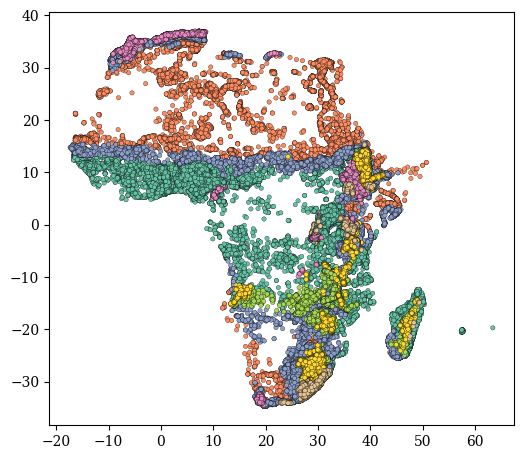

In [25]:
# Plot the sample points
samples_gdf.plot(column="clim_class", cmap="Set2", markersize=10, edgecolor="k", linewidth=0.2, figsize=(6, 6));

## **Sample NPP Yields for Each Country**

### **Filter out the FAO Yield Data for the available Date Range**

In [26]:
# Filter the yield dataframe from 2009-2022
fao_yield_df = fao_yield_df[(fao_yield_df["Year"]>=2008) & (fao_yield_df["Year"]<=2022)]
print(fao_yield_df.shape)
fao_yield_df.head()

(746, 5)


,Area,Element,Item,Year,Yield(tons/ha)
47,Algeria,Yield,Maize (corn),2008,4.4714
48,Algeria,Yield,Maize (corn),2009,3.0914
49,Algeria,Yield,Maize (corn),2010,2.5827
50,Algeria,Yield,Maize (corn),2011,2.3374
51,Algeria,Yield,Maize (corn),2012,2.5583


### **Assign Time Component to the NPP Data**

In [27]:
# Read the Terra Net Primary Production Global dataset
npp = ee.ImageCollection("FAO/WAPOR/2/L1_NPP_D")\
        .select("L1_NPP_D")\

# Write a function to map the time component in the NPP image collection
def assign_time_comp(image):

    time_index = ee.String(image.get("system:index")).slice(-4,)
    year = ee.Number(ee.String("20").cat(time_index.slice(0, 2)))
    dakad_id = ee.Number.parse(time_index.slice(2, ))

    end_day = ee.Number(dakad_id).multiply(ee.Number(10))
    start_day = ee.Number(end_day).subtract(ee.Number(10))

    # Define the start date and end date
    initial_date = ee.Date(year)
    start_day_date = initial_date.advance(start_day, "day")
    end_day_date = initial_date.advance(end_day, "day")

    return image.set({
        "start_date": start_day_date,
        "end_date": end_day_date,
        "system:time_start": start_day_date.millis(),
        "system:time_end": end_day_date.millis()
    })

# Apply the function over the image collection
npp_mapped = npp.map(assign_time_comp)

In [28]:
# Define the years to be taken
years = np.arange(2009, 2023)

### **Prepare Grid NPP and Disaggregated Yield**

In [29]:
# Define a function to get the grid NPP values
def get_grid_npp(country_name, year, crop_calendar_df):

    country_geom = roi_ee.filter(ee.Filter.eq("ADM0_NAME", country_name)).first()\
                         .geometry()

    plant_start = crop_calendar_df[crop_calendar_df["country"]==country_name]["plant_start"].values[0]
    harvest_end = crop_calendar_df[crop_calendar_df["country"]==country_name]["harvest_end"].values[0]

    # Extract the duration
    if plant_start > harvest_end:
        duration = (365 - plant_start) + harvest_end
    else:
        duration = harvest_end - plant_start

    # Define the start and end date
    initial_date = ee.Date(str(year))
    start_date = initial_date.advance(int(plant_start), "day")
    end_date = start_date.advance(int(duration), "day")

    # Filter out the NPP data for the growing days
    npp_filtered = npp_mapped.filterDate(start_date, end_date)

    # Calculate average NPP per pixel during the growing period
    npp_average_per_pixel = npp_filtered.mean()\
                                        .toInt()\
                                        .rename("average_npp")\
                                        .clip(country_geom)\
                                        .updateMask(esri_cropland_mask)

    # Calculate the mean country NPP 
    country_npp_mean = npp_average_per_pixel.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=country_geom.bounds(),
        scale=250, 
        maxPixels=1e16,
        bestEffort=True)

    # Get the average NPP of the country
    country_npp_mean = int(country_npp_mean.getInfo()["average_npp"])

    # Calculate the Ratio per pixel
    npp_ratio_per_pixel = npp_average_per_pixel.divide(country_npp_mean)\
                                               .toFloat()\
                                               .rename("ratio_npp")
    
    return npp_ratio_per_pixel

In [31]:
# Define a function to calculate disaggregated FAO Yield at pixel level
def get_grid_yield(country_name, year):
    
    double_cropping = None
    if (country_name in major_crop_calendar_df["country"].values) and (country_name in minor_crop_calendar_df["country"].values):
        double_cropping = True
    else:
        double_cropping = False

    # Extract the FAO yield value for the country of particular year
    fao_yield_value = fao_yield_df[(fao_yield_df["Area"]==country_name) & (fao_yield_df["Year"]==year)]["Yield(tons/ha)"].values[0]

    if double_cropping == True:
        major_npp_ratio_per_pixel = get_grid_npp(country_name, year, major_crop_calendar_df)
        minor_npp_ratio_per_pixel = get_grid_npp(country_name, year, minor_crop_calendar_df)

        # Distribute the FAO yield over the pixel
        npp_yield_per_pixel = ee.ImageCollection([major_npp_ratio_per_pixel, minor_npp_ratio_per_pixel])\
                                .mean()\
                                .multiply(fao_yield_value)\
                                .rename("disaggregated_yield")
    
    else:
        major_npp_ratio_per_pixel = get_grid_npp(country_name, year, major_crop_calendar_df)

        # Distribute the FAO yield over the pixel
        npp_yield_per_pixel = major_npp_ratio_per_pixel.multiply(fao_yield_value)\
                                                       .rename("disaggregated_yield")
        
    return npp_yield_per_pixel

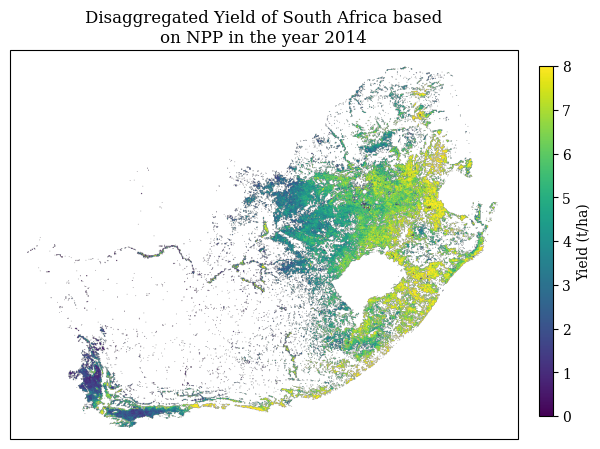

In [32]:
# Test the algortihm on South Africa for the year 2014
sa_npp_yield_2014 = get_grid_yield("South Africa", 2014)

# Plot the Maize harvested area
fig = plt.figure(figsize=(7, 7))

region = [15.84, -35.14, 33.59, -21.54]

ax = cartoee.get_map(sa_npp_yield_2014, 
                     cmap="viridis", 
                     vis_params={"min": 0, "max": 8},
                     region=region)

cb = cartoee.add_colorbar(ax=ax, vis_params={"min": 0, "max": 8}, loc="right", 
                          cmap="viridis", label="Yield (t/ha)")

ax.set_title("Disaggregated Yield of South Africa based\non NPP in the year 2014")

plt.show()

### **Apply the Functions over all the Countries for Different Years**

In [33]:
# # Create a final dataframe to store the samples of all the countries
# final_samples_yield = pd.DataFrame()

# # Iterate the function over all the countries
# for country in tqdm(sorted(samples_gdf["country"].unique())):

#     print("******************************************************************************************")

#     for year in years:

#         try:
#             country_samples = samples_ee.filter(ee.Filter.eq("country", country))
#             country_year_npp = get_grid_yield(country, year)

#             # Extract sample values
#             country_year_npp_samples = country_year_npp.reduceRegions(
#                 collection=country_samples, 
#                 reducer=ee.Reducer.first(),
#                 scale=250)
            
#             country_year_npp_samples_df = geemap.ee_to_df(country_year_npp_samples)

#             # Drop all the NaN values
#             country_year_npp_samples_df = country_year_npp_samples_df.dropna()

#             # Assign year value to the dataframe
#             country_year_npp_samples_df["year"] = year
#             country_year_npp_samples_df.rename(columns={"first": "yield(t/ha)"}, inplace=True)
#             country_year_npp_samples_df = country_year_npp_samples_df[["point_id", "country", "year", "yield(t/ha)", "clim_class"]]
            
#             final_samples_yield = pd.concat((final_samples_yield, country_year_npp_samples_df), axis=0, ignore_index=True)

#             print(country, " || ", year, " || ", "(Done)")

#         except:
#             print(country, " || ", year, " || ", "*******(Error)*******")
#             continue

In [34]:
# Save the final sample yield data
# final_samples_yield.to_csv(os.path.join(output_path, "africa_npp_yield_samples.csv"), index=False)

# Read the exported data
final_npp_yield_df = pd.read_csv(os.path.join(output_path, "africa_npp_yield_samples.csv"))
print(final_npp_yield_df.shape)
final_npp_yield_df.head()

(1108030, 5)


,point_id,country,year,yield(t/ha),clim_class
0,0,Algeria,2009,0.757956,4
1,1,Algeria,2009,0.082746,4
2,2,Algeria,2009,0.000000,4
3,3,Algeria,2009,0.029789,4
4,4,Algeria,2009,0.215140,4


### **Data Postprocessing**

In [151]:
# Delete the points having yield value less than 0
neg_yield_points = final_npp_yield_df[final_npp_yield_df["yield(t/ha)"]<0]["point_id"].unique()

# Remove all the negative yield poin indices
final_npp_yield_df = final_npp_yield_df[~final_npp_yield_df["point_id"].isin(neg_yield_points)]
print(final_npp_yield_df.shape)
final_npp_yield_df.head()

(1105776, 5)


,point_id,country,year,yield(t/ha),clim_class
0,0,Algeria,2009,0.757956,4
1,1,Algeria,2009,0.082746,4
2,2,Algeria,2009,0.000000,4
3,3,Algeria,2009,0.029789,4
4,4,Algeria,2009,0.215140,4


In [192]:
# Export the data
# final_npp_yield_df.to_csv(os.path.join(output_path, "africa_npp_yield_samples_ml.csv"), index=False)

In [35]:
# Convert the year into columns (pivot table)
npp_yield_pivot_df = final_npp_yield_df.pivot(index='point_id', columns='year', values='yield(t/ha)')
npp_yield_pivot_df["point_id"] = npp_yield_pivot_df.index
npp_yield_pivot_df.reset_index(drop=True, inplace=True)

# Merge the country, climate class
npp_yield_pivot_df = pd.merge(left=npp_yield_pivot_df, right=final_npp_yield_df.drop(columns=["yield(t/ha)", "year"]).drop_duplicates(),
                              on=["point_id"], how="left")
col_order = ["point_id", "country", "clim_class", 2009, 2010, 2011, 2012,
              2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
npp_yield_pivot_df = npp_yield_pivot_df[col_order]
print(npp_yield_pivot_df.shape)
npp_yield_pivot_df.head()

(79160, 17)


,point_id,country,clim_class,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0,Algeria,4,0.757956,0.421128,0.287430,0.209647,0.309974,0.219366,0.476216,0.393642,0.167712,0.439970,0.510047,0.894782,0.652629,0.651864
1,1,Algeria,4,0.082746,0.065801,0.065078,0.051652,0.067223,0.069943,0.082422,0.094004,0.037269,0.100565,0.087305,0.181990,0.132080,0.102253
2,2,Algeria,4,0.000000,0.000000,0.005423,0.000000,0.003735,0.003179,0.004579,0.000000,0.260885,0.025141,1.162541,0.136492,0.163157,0.115035
3,3,Algeria,4,0.029789,0.029611,0.027116,0.030384,0.037346,0.028613,0.041211,0.058753,0.022362,0.029331,0.050545,0.106161,0.054386,0.051127
4,4,Algeria,4,0.215140,0.233595,0.244044,0.255222,0.261424,0.305205,0.325109,0.475896,0.177029,0.339405,0.390577,0.492888,0.411778,0.402622


In [36]:
# Merge the geometry of the points
npp_yield_pivot_gdf = pd.merge(left=npp_yield_pivot_df, right=samples_gdf[["point_id", "geometry"]], on="point_id", how="left")
col_order = ["point_id", "country", "clim_class", 2009, 2010, 2011, 2012,
              2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, "geometry"]
npp_yield_pivot_gdf = gpd.GeoDataFrame(npp_yield_pivot_gdf, geometry="geometry")
npp_yield_pivot_gdf.columns = [str(col) for col in col_order]
print(npp_yield_pivot_gdf.shape)
npp_yield_pivot_gdf.head()

(79160, 18)


,point_id,country,clim_class,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,geometry
0,0,Algeria,4,0.757956,0.421128,0.287430,0.209647,0.309974,0.219366,0.476216,0.393642,0.167712,0.439970,0.510047,0.894782,0.652629,0.651864,POINT (5.23822 35.56770)
1,1,Algeria,4,0.082746,0.065801,0.065078,0.051652,0.067223,0.069943,0.082422,0.094004,0.037269,0.100565,0.087305,0.181990,0.132080,0.102253,POINT (1.79530 29.07367)
2,2,Algeria,4,0.000000,0.000000,0.005423,0.000000,0.003735,0.003179,0.004579,0.000000,0.260885,0.025141,1.162541,0.136492,0.163157,0.115035,POINT (6.43865 30.60756)
3,3,Algeria,4,0.029789,0.029611,0.027116,0.030384,0.037346,0.028613,0.041211,0.058753,0.022362,0.029331,0.050545,0.106161,0.054386,0.051127,POINT (9.38139 24.55536)
4,4,Algeria,4,0.215140,0.233595,0.244044,0.255222,0.261424,0.305205,0.325109,0.475896,0.177029,0.339405,0.390577,0.492888,0.411778,0.402622,POINT (2.47888 27.25634)


In [37]:
# Export the data
# npp_yield_pivot_df.to_csv(os.path.join(output_path, "africa_npp_yield_samples_eda.csv"), index=False)
# npp_yield_pivot_gdf.to_file(os.path.join(output_path, "africa_npp_yield_samples_eda.shp"), driver="ESRI Shapefile")

### **Exploratory Data Analysis**

In [40]:
# Read the EDA sample data
npp_yield_eda_df = pd.read_csv(os.path.join(output_path, "africa_npp_yield_samples_eda.csv"))
npp_yield_eda_gdf = gpd.read_file(os.path.join(output_path, "africa_npp_yield_samples_eda.shp"))

print(npp_yield_eda_df.shape)
print(npp_yield_eda_gdf.shape)

(78999, 17)
(78999, 18)
